In [76]:
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from IPython.display import Image
from sklearn.datasets import make_classification, make_blobs

# Analiza skupień metodą k-medoids 

### Co to jest klasteryzacja? 

&emsp;Analiza skupień lub klasteryzacja to zadanie polegające na grupowaniu zbioru obiektów w taki sposób, aby obiekty w tej samej grupie lub klastrze były do siebie bardziej podobne niż obiekty w innych grupach lub klastrach. 

&emsp;Idea algorytmu klastrowania:

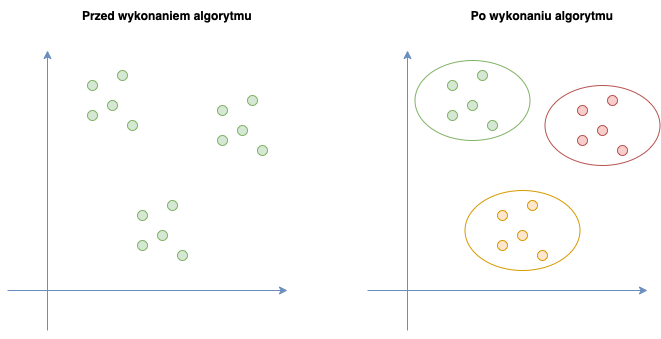

In [77]:
Image("algorithm.png")

&emsp;Sama analiza skupień nie jest jednym konkretnym algorytmem, lecz ogólnym zadaniem do rozwiązania. Można je zrealizować za pomocą różnych algorytmów (algorytm $k-średnich$, algorytm $k-medoid$), które różnią się znacznie w rozumieniu tego, czym jest klaster i jak skutecznie je znaleźć. Popularne pojęcia klastrów obejmują grupy o małych odległościach między elementami klastra. Klastrowanie można zatem sformułować jako wieloprzedmiotowy problem optymalizacyjny. Wybór odpowiedniego algorytmu grupowania i ustawień parametrów zależy od indywidualnego zbioru danych i przeznaczenia wyników. Analiza skupień jako taka nie jest zadaniem automatycznym, lecz iteracyjnym procesem odkrywania wiedzy lub interaktywnej optymalizacji wieloprzedmiotowej, który wymaga prób i błędów. Często konieczne jest modyfikowanie wstępnego przetwarzania danych i parametrów modelu, aż do uzyskania pożądanych właściwości.

&emsp;W naszym projekcie przedstawimy metodę $k-medoid$ i porównamy ją z metodą $k-średnich$.

### Algorytm k-średnich

&emsp;W uczeniu maszynowym występują głównie dwa rodzaje algorytmów uczenia. Są to algorytm uczenia nadzorowanego i algorytm uczenia nienadzorowanego. 
Klastrowanie metodą $k-średnich$ jest algorytmem uczenia nienadzorowanego, który grupuje nieoznakowane zbiory danych w różne klastry lub grupy. W algorytmie $k-średnich$ $k$ określa liczbę wstępnie zdefiniowanych klastrów lub grup, które należy utworzyć w danym zbiorze danych. Na przykład jeśli $k = 3$, powstaną trzy klastry, dla $k = 5$ będzie pięć klastrów itd.

&emsp;Algorytm $k-średnich$ pomaga grupować dane w różne klastry w sposób konwencjonalny, umożliwiając samodzielne odkrywanie kategorii grup w nieoznakowanym zbiorze danych bez konieczności uczenia. Algorytm klasteryzacji $k-średnich$ jest algorytmem opartym na centroidach, w którym każdy klaster jest powiązany z centroidem. Głównym celem tego algorytmu jest zminimalizowanie sumy odległości wewnętrznych punktów danych w odpowiadających im klastrach. Algorytm przyjmuje jako dane wejściowe nieuporządkowany zbiór danych i dzieli go na $k$ grup, a następnie powtarza ten proces aż do uzyskania najlepszych klastrów. Wartość $k$ jest zawsze określona z góry.

&emsp;Główne zadanie algorytmu $k-średnich$ jest następujące:

&emsp;&emsp;$1.$ Wybierz liczbę klastrów $k$.  
&emsp;&emsp;$2.$ Wybierz losowo $k$ punktów z zestawu danych jako centroidy.  
&emsp;&emsp;$3.$ Przypisz każdy punkt danych do najbliższego mu centroida.  
&emsp;&emsp;$4.$ Oblicz wariancję i umieść nowy centroid dla każdego klastra.  
&emsp;&emsp;$5.$ Powtórz $krok 3$, czyli ponownie przypisz każdy punkt danych do nowego najbliższego centroidu.

&emsp;**Rozwiązanie**: Implementacja algorytmu $k-średnich$ przy użyciu Pythona. Do wykonania algorytmu $k-średnich$ potrzebne jest wstępne przetwarzanie danych. W naszym rozwiązaniu przeprowadziliśmy wstępne przetwarzanie danych w celu zaimplementowania algorytmu. Dodatkowo oceniliśmy jaka jest jakość naszego grupowania. Posłużyliśmy się tzw. sylwetką (ang. silhouette) $s(x_i)$ obliczaną dla każdego obiektu $x_i$. Najpierw dla $x_i$ znajduje się jego średnią odległość $a(x_i)$ od pozostałych obiektów grupy, do której został przydzielony, a następnie wybiera się minimalną wartość $b(x_i)$ spośród obliczonych odległości od $x_i$ do każdej spośród pozostałych grup osobno. Odległość $x_i$ od danej grupy oblicza się jako średnią odległość od $x_i$ do wszystkich elementów tej grupy. Obie wielkości zestawia się we wzorze: 

<h1><center>$s(x_i) = \frac{b(x_i)-a(x_i)}{max(a(x_i),b(x_i))}$</center></h1>

otrzymując wartość sylwetki dla danego obiektu $x_i$. Jej zbiór wartości to $[-1, 1]$. Zatem ma ona prostą interpretację: obiekty, dla których wskaźnik jest bliski $1$, zostały trafnie zgrupowane, pozostałe (o wartości ok. $0$ i $ujemnej$) prawdopodobnie trafiły do złych grup.

In [118]:
class TrainModel_means:
    def __init__(self, data, k_value, max_iteration):
        self.data = data
        scaler = MinMaxScaler()
        self.data = scaler.fit_transform(self.data)
        self.k_value = k_value
        self.max_iteration = max_iteration
        self.centroids = []
        self.final_clusters, self.silhouette = self.data_cluster()

    def generate_column(self, col, data):
        values = []
        for i in range(len(data)):
            values.append(data[i][col])
        return values

    def calculateDistance(self, x, y):
        return np.linalg.norm(x-y)

    def get_closest_centroid(self, points, centroids):
        closest_centroids = []
        for i in points:
            distance = []
            for c in centroids:
                dis = self.calculateDistance(i, c)
                distance.append(dis)
            closest_centroids.append(np.argmin(distance))
        return closest_centroids

    def calculate_new_centroids(self, clusters, X):
        new_centroids = []
        new_df = pd.concat([pd.DataFrame(X), pd.DataFrame(clusters, columns=['cluster'])], axis=1)
        for c in set(new_df['cluster']):
            current_cluster = new_df[new_df['cluster'] == c][new_df.columns[:-1]]
            cluster_mean = current_cluster.mean(axis=0)
            new_centroids.append(cluster_mean)
        return new_centroids

    def get_clustered_data(self, points, centroids):
        closest_centroids = self.get_closest_centroid(points, centroids)
        clustered_data = {}
        for i in range(self.k_value):
            clustered_data[i] = []
        for i in range(len(points)):
            clustered_data[closest_centroids[i]].append(points[i])
        return clustered_data

    def get_clusters_label(self, data_points, clusters):
        labels = []
        for i in range(len(data_points)):
            labels.append(0)
        for i in clusters.keys():
            cluster = clusters[i]
            for j in range(len(cluster)):
                for k in range(len(data_points)):
                    if (cluster[j] == data_points[k]).all():
                        labels[k] = i
                        break
        return labels

    def data_cluster(self):
        centroid_points = random.sample(range(0, len(self.data)), self.k_value)
        for i in centroid_points:
            self.centroids.append(self.data[i])
        for i in range(self.max_iteration):
            closest_centroids = self.get_closest_centroid(self.data, self.centroids)
            self.centroids = self.calculate_new_centroids(closest_centroids, np.array(self.data))
        final_clusters = self.get_clustered_data(self.data, self.centroids)
        cluster_labels = self.get_clusters_label(self.data, final_clusters)
        silhouette_avg = silhouette_score(self.data, cluster_labels)
        print("Sylwetka (ang.silhouette) dla metody k-średnich i dla k =", self.k_value, round(silhouette_avg,2))
        
        return final_clusters, round(silhouette_avg,2)
        
    def return_values(self):
        return self.centroids, self.final_clusters, self.silhouette

In [130]:
# iris
dataset = pd.read_csv('iris.csv')
dataset = dataset.iloc[: , 1:-1]
dataset = dataset.values
model = TrainModel_means(dataset, 3, 10)
centroids, final_clusters, silhouette = model.return_values()

Sylwetka (ang.silhouette) dla metody k-średnich i dla k = 3 0.44


In [131]:
# glass
dataset2= pd.read_csv('glass.csv')
dataset2 = dataset2.iloc[:,:-1]
dataset2 = dataset2.values
model2 = TrainModel_means(dataset2, 4, 10)
centroids2, final_clusters2, silhouette2 = model2.return_values()

Sylwetka (ang.silhouette) dla metody k-średnich i dla k = 4 0.33


In [132]:
# wine
dataset3= pd.read_csv('wine.csv')
dataset3 = dataset3.values
model3 = TrainModel_means(dataset3, 3, 10)
centroids3, final_clusters3, silhouette3 = model3.return_values()

Sylwetka (ang.silhouette) dla metody k-średnich i dla k = 3 0.3


### Algorytm k-medoid

$1.$ Inicjalizacja: wybierz $k$ losowych punktów spośród $n$ punktów danych jako medoidy.  
$2.$ Przyporządkuj każdy punkt danych do najbliższego medoidu, używając dowolnych popularnych metod metryki odległości.  
$3.$ Podczas gdy koszt maleje:  
&emsp;&emsp;Dla każdej medoidy $m$, dla każdego punktu danych $o$, który nie jest medoidą:  
&emsp;&emsp;&emsp;&emsp;$i.$ Zamień punkty $m$ i $o$, przyporządkuj każdy punkt danych do najbliższej medoidy, ponownie oblicz koszt.  
&emsp;&emsp;&emsp;&emsp;$ii.$ Jeśli całkowity koszt jest większy niż w poprzednim kroku, cofnij zamianę.

&emsp;**Rozwiązanie**: Implementacja algorytmu k-medoid w Pythonie. Do wykonania algorytmu k-medoidy potrzebne jest wstępne przetworzenie danych. W naszym rozwiązaniu przeprowadziliśmy wstępne przetwarzanie danych w celu zaimplementowania algorytmu k-medoid. 

In [102]:
class TrainModel_medoids:
    def __init__(self, data, k_value):
        self.data = data
        scaler = MinMaxScaler()
        self.data = scaler.fit_transform(self.data)
        self.k_value = k_value
        self.medoids, self.res_cluster, self.cluster_labels, self.silhouette = self.kmedoids(self.data)

    def get_random_medoids(self, data):
        points = random.sample(range(0, len(data)), self.k_value)
        medoids = []
        for i in points:
            medoids.append(data[i])
        return medoids

    def get_closest_medoids(self, sample_point, medoids):
        min_distance = float('inf')
        closest_medoid = None
        for i in range(len(medoids)):
            distance = self.calculateDistance(sample_point, medoids[i])
            if distance < min_distance:
                min_distance = distance
                closest_medoid = i
        return closest_medoid

    def get_clusters(self, data_points, medoids):
        clusters = [[] for _ in range(self.k_value)]
        for i in range(len(data_points)):
            x = self.get_closest_medoids(data_points[i], medoids)
            clusters[x].append(data_points[i])
        return clusters

    def calculate_cost(self, data_points, clusters, medoids):
        cost = 0
        for i in range(len(clusters)):
            for j in range(len(clusters[i])):
                cost += self.calculateDistance(medoids[i], clusters[i][j])
        return cost

    def get_non_medoids(self, data_points, medoids):
        non_medoids = []
        for sample in data_points:
            flag = False
            for m in medoids:
                if (sample == m).all():
                    flag = True
            if flag == False:
                non_medoids.append(sample)
        return non_medoids

    def get_clusters_label(self, data_points, clusters):
        labels = []
        for i in range(len(data_points)):
            labels.append(0)
        for i in range(len(clusters)):
            cluster = clusters[i]
            for j in range(len(cluster)):
                for k in range(len(data_points)):
                    if (cluster[j] == data_points[k]).all():
                        labels[k] = i
                        break
        return labels
    
    def plot_results(self, clusters, medoids):
        colors = ['b', 'g', 'r', 'c', 'm', 'k']
        X = []
        Y = []
        plt.figure(figsize=(10,8))
        for i in range(self.k_value):
            X.append(np.squeeze(clusters[i])[:, 0])
            Y.append(np.squeeze(clusters[i])[:, 1])

        for i in range(len(X)):
            plt.scatter(X[i], Y[i], c=colors[i])

        mx = []
        my = []

        for m in medoids:
            mx.append(m[0])
            my.append(m[1])

        plt.scatter(mx, my, c='yellow', marker='*')
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title(f"K-medoids. Number of clusters: {self.k_value}")
        plt.show()
        time.sleep(4)

    def kmedoids(self, data):
        medoids = self.get_random_medoids(data)
        clusters = self.get_clusters(data, medoids)
        initial_cost = self.calculate_cost(data, clusters, medoids)
        while True:
            best_medoids = medoids
            lowest_cost = initial_cost
            for i in range(len(medoids)):
                non_medoids = self.get_non_medoids(data, medoids)
                for j in range(len(non_medoids)):
                    new_medoids = medoids.copy()
                    for k in range(len(new_medoids)):
                        if (new_medoids[k] == medoids[i]).all():
                            new_medoids[k] = non_medoids[j]
                    new_clusters = self.get_clusters(data, new_medoids)
                    new_cost = self.calculate_cost(data, new_clusters, new_medoids)
                    if new_cost < lowest_cost:
                        lowest_cost = new_cost
                        best_medoids = new_medoids
            if lowest_cost < initial_cost:
                initial_cost = lowest_cost
                medoids = best_medoids
            else:
                break
        final_clusters = self.get_clusters(data, medoids)
        cluster_labels = self.get_clusters_label(data, final_clusters)
        silhouette_avg = silhouette_score(data, cluster_labels)
        self.plot_results(final_clusters, medoids)

        print("Sylwetka (ang.silhouette) dla metody k-medoid i dla k =", self.k_value, round(silhouette_avg,2))

        res_cluster = []
        for i in range(0, self.k_value):
            res_cluster.append([data[s] for s in range(0, len(data)) if cluster_labels[s] == i])
        return medoids, res_cluster, cluster_labels, round(silhouette_avg,2)

    def calculateDistance(self, x, y):
        return np.linalg.norm(x-y)

    def return_values(self):
        return self.medoids, self.res_cluster, self.cluster_labels, self.silhouette

#### Uruchomienie algorytmu k-medoid dla zbioru danych iris

In [84]:
# iris
model4 = TrainModel_medoids(dataset, 3)
medoids4, res_cluster4, cluster_labels4, silhouette4 = model4.return_values()

res = res_cluster4[0] + res_cluster4[1] + res_cluster4[2]

medoids_values = []
for i in range(0, len(res_cluster4[0])):
    medoids_values.append(0)
    
for i in range(0, len(res_cluster4[1])):
    medoids_values.append(1)
    
for i in range(0, len(res_cluster4[2])):
    medoids_values.append(2)


data = {'Długość kielicha': [round(res[i][0],2) for i in range(0, len(res))],
        'Szerokość kielicha': [round(res[i][1],2) for i in range(0, len(res))],
        'Długość płatka': [round(res[i][2],2) for i in range(0, len(res))],
        'Szerokość płatka': [round(res[i][3],2) for i in range(0, len(res))],
        'Wartość medoidu 0': [(round(medoids4[0][0],2),round(medoids4[0][1],2), round(medoids4[0][2],2), round(medoids4[0][3],2)) for i in range(150)],
        'Wartość medoidu 1': [(round(medoids4[1][0],2), round(medoids4[1][1],2), round(medoids4[1][2],2), round(medoids4[1][3],2)) for i in range(150)],
        'Wartość medoidu 2': [(round(medoids4[2][0],2), round(medoids4[2][1],2), round(medoids4[2][2],2), round(medoids4[2][3],2)) for i in range(150)],
        'Medoid': medoids_values}
df = pd.DataFrame(data)
df.to_csv('iris_data.csv')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 5)
display(df)

Sylwetka (ang.silhouette) dla metody k-medoid i dla k = 3 0.48


Długość kielicha  \
0          0.17         
1          0.17         
2          0.75         
3          0.58         
4          0.72         
5          0.33         
6          0.61         
7          0.39         
8          0.56         
9          0.17         
10         0.64         
11         0.25         
12         0.19         
13         0.44         
14         0.47         
15         0.50         
16         0.36         
17         0.67         
18         0.36         
19         0.42         
20         0.53         
21         0.36         
22         0.44         
23         0.50         
24         0.56         
25         0.50         
26         0.58         
27         0.64         
28         0.69         
29         0.47         
30         0.39         
31         0.33         
32         0.33         
33         0.42         
34         0.47         
35         0.31         
36         0.47         
37         0.67         
38         0.56         
39         0.36         
40         0.33         
41         0.33         
42         0.50         
43         0.42         
44         0.19         
45         0.36         
46         0.39         
47         0.39         
48         0.53         
49         0.22         
50         0.39         
51         0.42         
52         0.17         
53         0.39         
54         0.47         
55         0.36         
56         0.56         
57         0.53         
58         0.50         
59         0.56         
60         0.50         
61         0.47         
62         0.42         
63         0.56         
64         0.44         
65         0.22         
66         0.17         
67         0.11         
68         0.08         
69         0.19         
70         0.31         
71         0.08         
72         0.19         
73         0.03         
74         0.17         
75         0.31         
76         0.14         
77         0.14         
78         0.00         
79         0.42         
80         0.39         
81         0.31         
82         0.22         
83         0.39         
84         0.22         
85         0.31         
86         0.22         
87         0.08         
88         0.22         
89         0.14         
90         0.19         
91         0.19         
92         0.25         
93         0.25         
94         0.11         
95         0.14         
96         0.31         
97         0.25         
98         0.33         
99         0.19         
100        0.33         
101        0.03         
102        0.22         
103        0.19         
104        0.06         
105        0.03         
106        0.19         
107        0.22         
108        0.14         
109        0.22         
110        0.08         
111        0.28         
112        0.19         
113        0.67         
114        0.56         
115        0.78         
116        0.56         
117        0.61         
118        0.92         
119        0.83         
120        0.67         
121        0.81         
122        0.61         
123        0.58         
124        0.69         
125        0.42         
126        0.58         
127        0.61         
128        0.94         
129        0.94         
130        0.72         
131        0.94         
132        0.67         
133        0.81         
134        0.58         
135        0.81         
136        0.86         
137        1.00         
138        0.58         
139        0.94         
140        0.56         
141        0.58         
142        0.72         
143        0.67         
144        0.72         
145        0.69         
146        0.67         
147        0.67         
148        0.61         
149        0.53         

     Szerokość kielicha  \
0           0.46          
1           0.46          
2           0.50          
3           0.50          
4           0.46          
5           0.12          
6           0.33          
7           0

#### Uruchomienie algorytmu k-medoid dla zbioru danych glass

In [85]:
# glass
model5 = TrainModel_medoids(dataset2, 4)
medoids5, res_cluster5, cluster_labels5, silhouette5 = model5.return_values()

Sylwetka (ang.silhouette) dla metody k-medoid i dla k = 4 0.35


#### Uruchomienie algorytmu k-medoid dla zbioru danych wine

In [86]:
# wine
model6 = TrainModel_medoids(dataset3, 3)
medoids6, res_cluster6, cluster_labels6, silhouette6 = model6.return_values()

Sylwetka (ang.silhouette) dla metody k-medoid i dla k = 3 0.28


### Algorytm k-medoid + PCA

In [87]:
pca = PCA(n_components=2)

#### Redukcja wymiaru z 4 do 2 przy pomocy PCA na zbiorze danych iris

In [88]:
pca.fit(dataset)
dataset_pca = pca.transform(dataset)

In [94]:
# iris
model7 = TrainModel_medoids(dataset_pca, 3)
medoids7, res_cluster7, cluster_labels7, silhouette7 = model7.return_values()

Sylwetka (ang.silhouette) dla metody k-medoid i dla k = 3 0.5


#### Redukcja wymiaru z 9 do 2 przy pomocy PCA na zbiorze danych glass

In [95]:
pca.fit(dataset2)
dataset2_pca = pca.transform(dataset2)

In [96]:
# glass
model8 = TrainModel_medoids(dataset2_pca, 4)
medoids8, res_cluster8, cluster_labels8, silhouette8 = model8.return_values()

Sylwetka (ang.silhouette) dla metody k-medoid i dla k = 4 0.5


#### Redukcja wymiaru z 13 do 2 przy pomocy PCA na zbiorze danych wine

In [98]:
pca.fit(dataset3)
dataset3_pca = pca.transform(dataset3)

In [101]:
# wine
model9 = TrainModel_medoids(dataset3_pca, 3)
medoids9, res_cluster9, cluster_labels9, silhouette9 = model9.return_values()

Sylwetka (ang.silhouette) dla metody k-medoid i dla k = 3 0.45


### Porównanie metody k-średnich, k-medoid, k-medoid + PCA

&emsp;W celu porównania przedstawionych powyżej trzech metod został stworzony wykres. Na wykresie zostały porównane wartości sylwetek trzech metod na trzech zbiorach danych (iris, glass, wine): 

In [133]:
result_data = {'Iris': [silhouette, silhouette4, silhouette7],
              'Glass': [silhouette2, silhouette5, silhouette8],
              'Wine': [silhouette3, silhouette6, silhouette9]}
df_shoulette = pd.DataFrame(result_data)
df_shoulette.index = ['k-średnich', 'k-medoid', 'k-medoid + PCA']

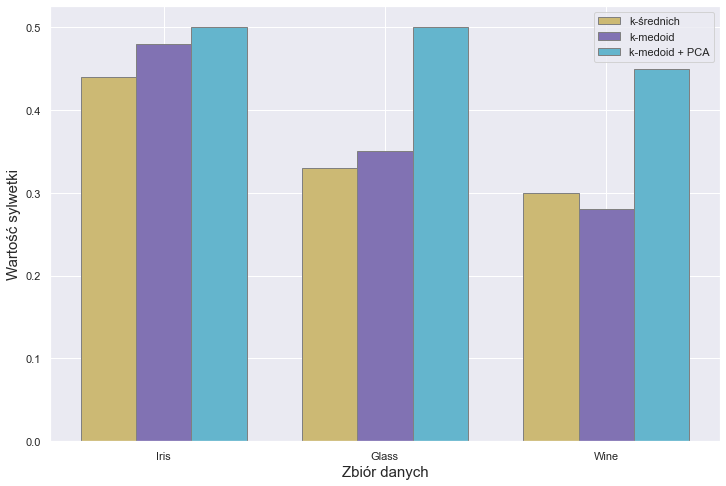

In [134]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

iris = [silhouette, silhouette2, silhouette3]
glass = [silhouette4, silhouette5, silhouette6]
wine = [silhouette7, silhouette8, silhouette9]

br1 = np.arange(len(iris))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, iris, color ='y', width = barWidth, edgecolor ='grey', label ='k-średnich')
plt.bar(br2, glass, color ='m', width = barWidth, edgecolor ='grey', label ='k-medoid')
plt.bar(br3, wine, color ='c', width = barWidth, edgecolor ='grey', label ='k-medoid + PCA')

plt.xlabel('Zbiór danych', fontsize = 15)
plt.ylabel('Wartość sylwetki', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(iris))], ['Iris', 'Glass', 'Wine'])

plt.legend()
plt.show()

In [135]:
df_shoulette

Iris  \
k-średnich      0.44   
k-medoid        0.48   
k-medoid + PCA  0.50   

                Glass  \
k-średnich      0.33    
k-medoid        0.35    
k-medoid + PCA  0.50    

                Wine  
k-średnich      0.30  
k-medoid        0.28  
k-medoid + PCA  0.45

&emsp;W wyniku tego porównania można dojść do wniosku, że najlepszą z metod jest metoda k-medoid wraz z redukcją wymiaru zbiorów danych przy pomocy PCA. 

### K-medoids na innych zbiorach danych

In [106]:
# Load datasets

dataset = np.array([[5, 6], [4, 7], [4, 8], [4, 6], [5, 7], [5, 8], [7, 6], [8, 8], [7, 7], [7, 8]])
dataset3 = np.array(
    [[4.5, 6], [4, 7], [4, 8], [4, 6], [4.5, 7], [4.5, 8], [7, 6], [5.5, 7], [5.5, 8], [5.5, 6], [8, 8], [7, 7],
     [7, 8]])

X1, Y1 = make_blobs(n_features=2, centers=4)
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=2, class_sep=2, flip_y=0, weights=[0.5, 0.5], random_state=17)

In [107]:
def print_sns_plot(data):
    column_values = ['x', 'y']
    df = pd.DataFrame(data=data, columns=column_values, index=None)
    sns.set_theme(style='darkgrid')
    plt.figure(figsize=(10,8))
    plt.title("Dataset for clustering")
    sns.scatterplot(data=df, x='x', y='y')
    plt.show()
    time.sleep(4)

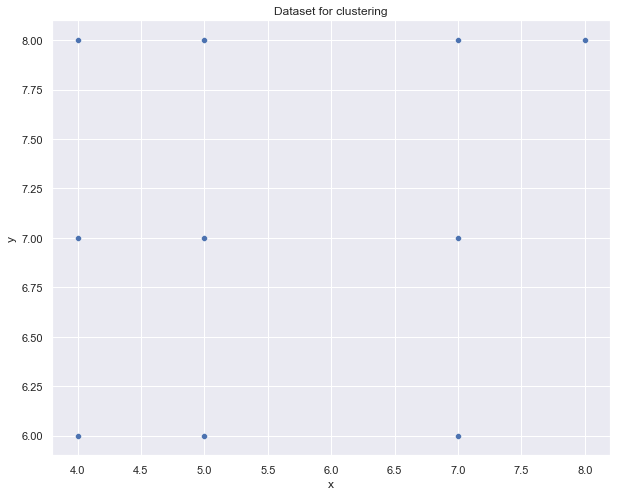

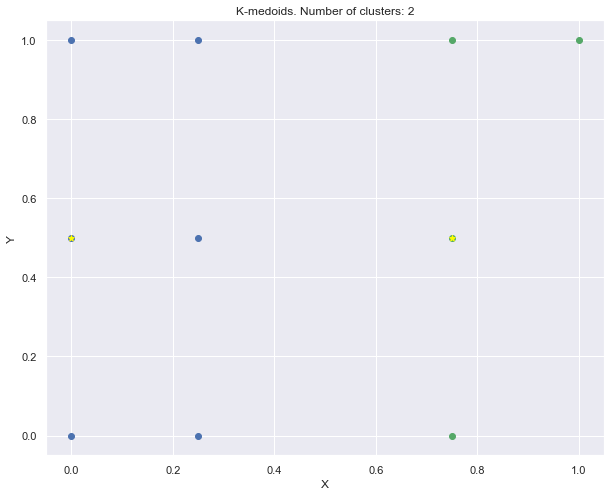

Sylwetka (ang.silhouette) dla metody k-medoid i dla k = 2 0.3


In [108]:
# 2 clusters
print_sns_plot(dataset)
model9 = TrainModel_medoids(dataset, 2)

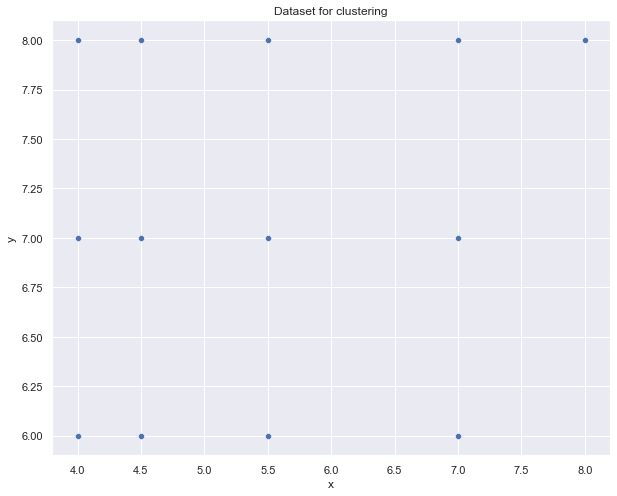

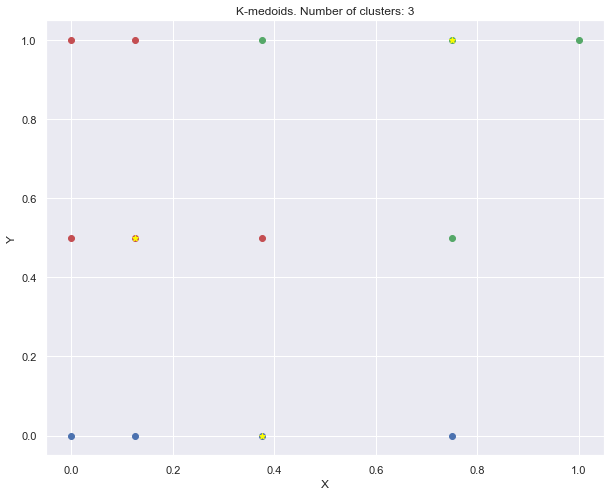

Sylwetka (ang.silhouette) dla metody k-medoid i dla k = 3 0.36


In [109]:
print_sns_plot(dataset3)
model10 = TrainModel_medoids(dataset3, 3)

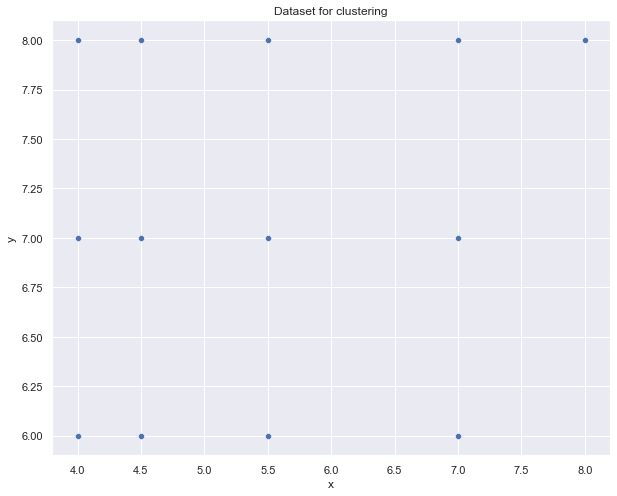

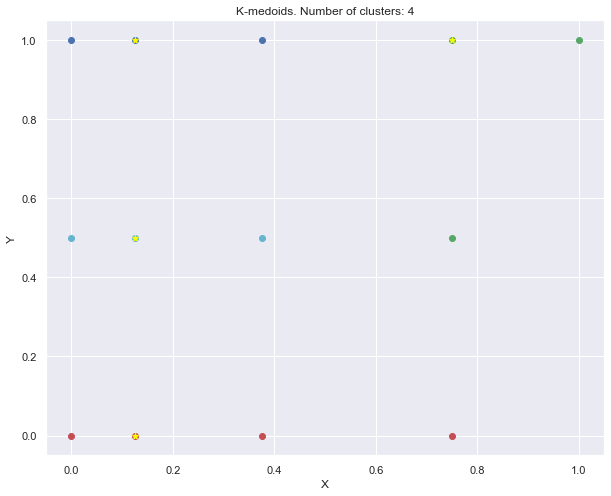

Sylwetka (ang.silhouette) dla metody k-medoid i dla k = 4 0.42


In [110]:
print_sns_plot(dataset3)
model11 = TrainModel_medoids(dataset3, 4)

### Przykłady z syntetycznymi zbiorami danych

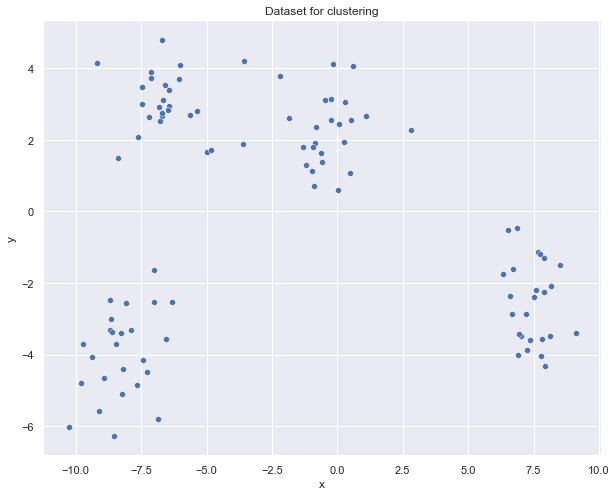

In [111]:
# Dataset with 4 centers
X1, Y1 = make_blobs(n_features=2, centers=4)
print_sns_plot(X1)

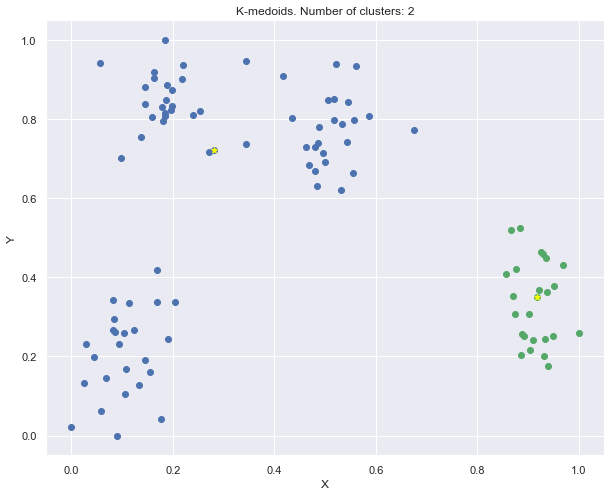

Sylwetka (ang.silhouette) dla metody k-medoid i dla k = 2 0.53


In [112]:
model12 = TrainModel_medoids(X1, 2)

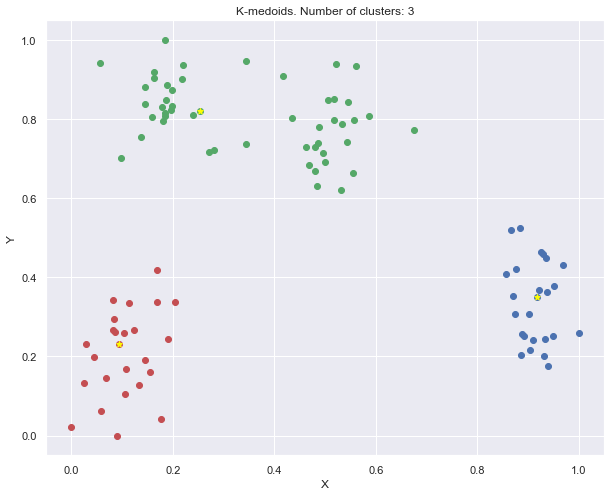

Sylwetka (ang.silhouette) dla metody k-medoid i dla k = 3 0.7


In [113]:
model13 = TrainModel_medoids(X1, 3)

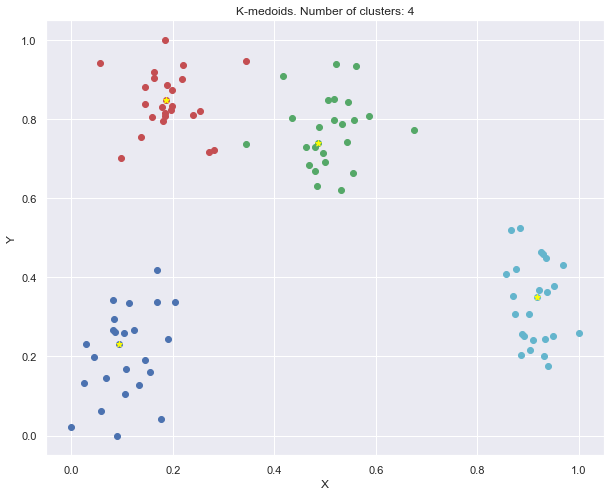

Sylwetka (ang.silhouette) dla metody k-medoid i dla k = 4 0.69


In [114]:
model14 = TrainModel_medoids(X1, 4)

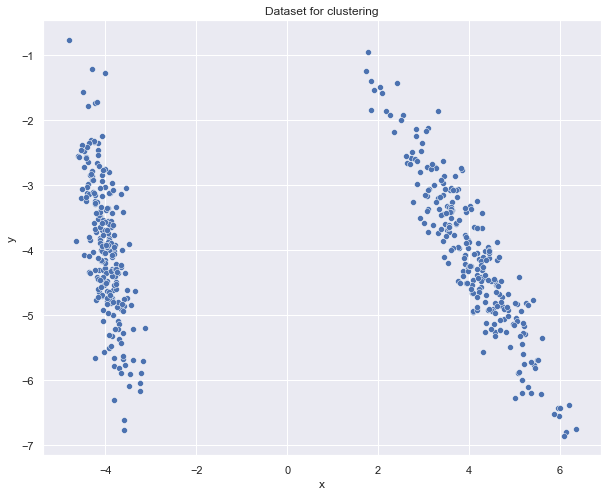

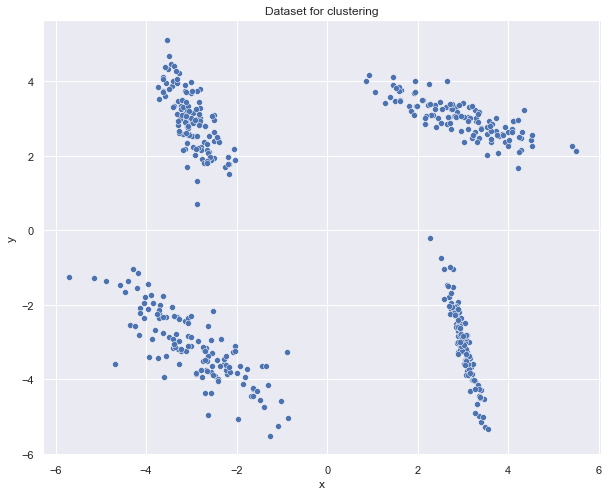

In [115]:
# 2 clusters
X2, y2 = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1, class_sep=4, flip_y=0, weights=[0.5, 0.5], random_state=17)
print_sns_plot(X2)

# 4 clusters
X3, y3 = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=2, class_sep=3, flip_y=0, weights=[0.5, 0.5], random_state=17)
print_sns_plot(X3)

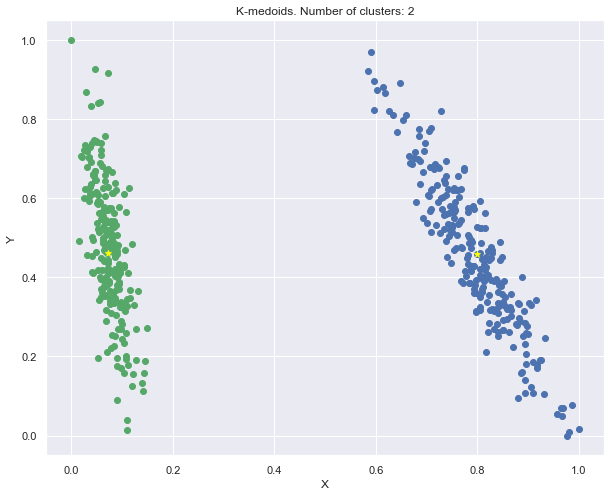

Sylwetka (ang.silhouette) dla metody k-medoid i dla k = 2 0.72


In [116]:
model15 = TrainModel_medoids(X2, 2)

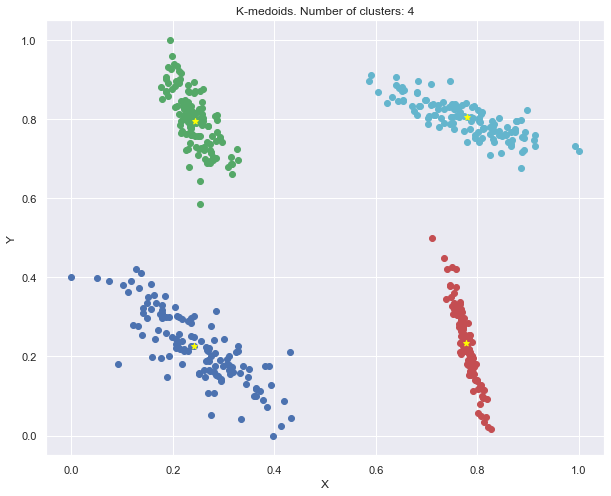

Sylwetka (ang.silhouette) dla metody k-medoid i dla k = 4 0.77


In [117]:
model16 = TrainModel_medoids(X3, 4)